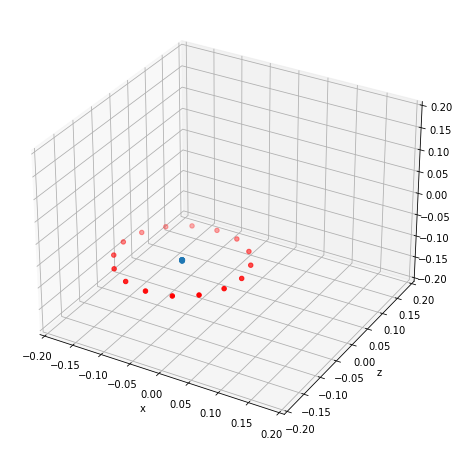

In [5]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt

rootdir = os.path.abspath(sys.path[0] + '/../')
sys.path.append(rootdir)

from utils import img
from utils.view import *
from utils import sphere


datadir = f'{rootdir}/data/eccv/cafe'

poses_bounds = np.load(f'{datadir}/poses_bounds.npy')
#poses_bounds2 = np.load(f'{rootdir}/data/eccv/barbershop/poses_bounds.npy')
#poses_bounds[..., 14:] = poses_bounds2[..., 14:]
#poses_bounds[..., 4] = poses_bounds2[..., 4]
#poses_bounds[..., 9] = poses_bounds2[..., 9]
#np.save(f'{rootdir}/data/eccv/stones/poses_bounds.npy', poses_bounds)
#raise Exception()
m = poses_bounds[..., :15].reshape(-1, 3, 5)
#print(m)
clip_planes = poses_bounds[..., 15:]
p = m[..., :, 4]
m = np.concatenate([
    m[..., :, :4],
    np.expand_dims(np.array([[0, 0, 0, 1]]), axis=0).repeat(m.shape[0], axis=0)
], axis=-2)
#m = np.linalg.inv (m)
t = m[..., :3, 3]
#t[..., 2] *= -1
r = m[..., :3, :3]
#r[..., 2] *= -1
#r[..., 2, :] *= -1
#print(clip_planes)
#print(p)
#print(t)
m = m.reshape(-1, 16)
#for i in range(16):
#    print("new[]{", ",".join(["%.4e" % val for val in m[i]]), "},")

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
plt.xlabel('x')
plt.ylabel('z')
ax.scatter(t[:, 0], t[:, 2], t[:, 1])
ax.scatter(t[:, 0] + r[:, 0, 2] * 0.1,
        t[:, 2] + r[:, 2, 2] * 0.1,
        t[:, 1] + r[:, 1, 2] * 0.1,
        color="r")

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)

images = img.load_seq(f'{datadir}/img%02d.png', 16, permute=False)
res=(int(p[0, 0]), int(p[0, 1]))
cam = Camera({"fy":-p[0, 2], "fx": p[0, 2], "cx":res[1]//2, "cy":res[0]//2}, res)
views = Trans(torch.tensor(t, dtype=torch.float), torch.tensor(r, dtype=torch.float))
_rays_o, _rays_d = cam.get_global_rays(views, flatten=True)
_patches = images.flatten(1, 2)
selector = torch.arange(res[0] * res[1]).reshape(res[0], res[1])[::3, ::3].flatten()

for ri in range(0, 0):
    r = ri * 2 + 2
    p = None
    centers = None
    pixels = None
    idx = 0
    
    for idx in [0, 1, 15]:
        patches = _patches[idx, selector]
        rays_o = _rays_o[idx, selector]
        rays_d = _rays_d[idx, selector]
        r = torch.tensor([[r]])
        p_ = misc.torch2np(sphere.ray_sphere_intersect(rays_o, rays_d, r)[0].view(-1, 3))
        p = p_ if p is None else np.concatenate((p, p_), axis=0)
        pixels_ = misc.torch2np(patches)
        pixels = pixels_ if pixels is None else np.concatenate((pixels, pixels_), axis=0)
        idx += 1
    plt.figure(facecolor='white', figsize=(20, 20))
    ax = plt.axes(projection='3d')
    #ax = plt.subplot(1, 2, ri % 2 + 1, projection='3d')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('r = %f' % r)
    ax.scatter([0], [0], [0], color="k", s=10)
    ax.scatter(p[:, 0], p[:, 2], p[:, 1], color=pixels, s=0.5)
    ax.view_init(elev=0, azim=-90)
